In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from keras.models import Sequential, Model
from keras.layers import Dense,InputLayer,Input
from keras.layers import Conv2D,Flatten,Reshape,MaxPool2D,UpSampling2D,MaxPooling2D,Conv2DTranspose

import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt

import cv2
import os
import pickle
import random
import collections

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, multilabel_confusion_matrix

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# MNIST

### Load Dataset

In [ ]:
from tensorflow.keras.datasets import mnist
# Cargar Dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalizar
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Aplicar Flatten
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
#X_train.shape
#X_test.shape

In [ ]:
#### Aplicando Ruido a ambos conjuntos
# Parametros
_mean = 0.0
_desv = 0.3

# Trainning set
noise = np.random.normal(loc = _mean, scale = _desv, size=X_train.shape)
X_train_noisy = X_train + noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

# Testing set
noise = np.random.normal(loc = _mean, scale = _desv, size=X_test.shape)
X_test_noisy = X_test + noise
X_test_noisy = np.clip(X_test_noisy, 0., 1.)


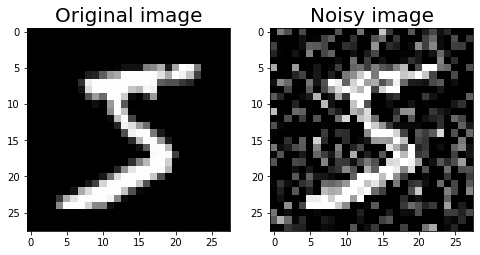

In [ ]:
fig=plt.figure(figsize=(8, 8))

img = X_train[0].reshape(28, 28)
fig.add_subplot(1, 2, 1)
plt.title('Original image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_train_noisy[0].reshape(28, 28)
fig.add_subplot(1, 2, 2)
plt.title('Noisy image', fontsize=20)
plt.imshow(img, cmap = 'gray')

plt.show()

### Densa

In [ ]:
ENC_DIM = 32
BATCH_SIZE = 256
EPOCHS = 50

#### Deep Encoder - Shallow Decoder [3-1]

##### Arquitectura

In [ ]:
# Arquitectura
def Red(encoding_dim):
  input_img = Input(shape=(784,))

  # Encoder Layers
  x = Dense(encoding_dim * 8, activation='relu')(input_img)
  x = Dense(encoding_dim * 2, activation='relu')(x)
  encoded = Dense(encoding_dim, activation='relu', name='embedding')(x)

  # Decoder Layers
  decoded = Dense(784, activation='sigmoid')(encoded)

  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  return (autoencoder,encoder)


AE_Dense_n_1, E_Dense_N_1 = Red(ENC_DIM)
AE_Dense_n_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
embedding (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 784)               25872     
Total params: 245,360
Trainable params: 245,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
AE_Dense_n_1.fit(X_train, X_train_noisy, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, X_test_noisy))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.5351 - val_loss: 0.4887
Epoch 2/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4861 - val_loss: 0.4834
Epoch 3/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.4801 - val_loss: 0.4759
Epoch 4/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.4709 - val_loss: 0.4655
Epoch 5/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.4617 - val_loss: 0.4575
Epoch 6/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.4553 - val_loss: 0.4525
Epoch 7/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4511 - val_loss: 0.4488
Epoch 8/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4477 - val_loss: 0.4456
Epoch 9/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.4449 - val_loss: 0.4431
Epoch

##### Resultados

In [ ]:
# Predict
X_decoded_Dense_n_1 = AE_Dense_n_1.predict(X_test_noisy)

image 5923


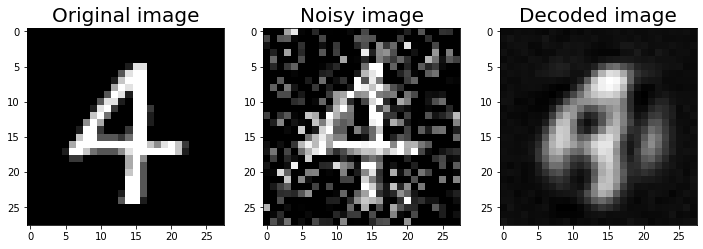

In [ ]:
fig=plt.figure(figsize=(12, 12))

_img = np.random.randint(X_test.shape[0])
_img = 5923
print(f'image {_img}')
img = X_test[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 1)
plt.title('Original image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_test_noisy[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 2)
plt.title('Noisy image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_decoded_Dense_n_1[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 3)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap = 'gray')

plt.show()

##### Representación latente aplicada

In [ ]:
# Representación latente
encoded_test_Dense_n_1 = E_Dense_N_1.predict(X_test)
encoded_train_Dense_n_1 = E_Dense_N_1.predict(X_train)

In [ ]:
modelaux = Sequential([
  Dense(64, activation='relu', input_shape=(ENC_DIM,)),
  Dense(32, activation='relu'),
  Dense(10, activation='softmax'),])

# Compilado
modelaux.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

# One-hot-encoding
Y_test_oneHot = keras.utils.to_categorical(Y_test, num_classes=10)
Y_train_oneHot = keras.utils.to_categorical(Y_train, num_classes=10)

modelaux.fit(encoded_train_Dense_n_1, Y_train_oneHot,batch_size=256,epochs=20)

Epoch 1/20
60000/60000 [==============================] - 1s 12us/step - loss: 1.4185 - accuracy: 0.6040
Epoch 2/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.4796 - accuracy: 0.8549
Epoch 3/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.3984 - accuracy: 0.8789
Epoch 4/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.3540 - accuracy: 0.8914
Epoch 5/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.3244 - accuracy: 0.9009
Epoch 6/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2980 - accuracy: 0.9097
Epoch 7/20
60000/60000 [==============================] - 1s 10us/step - loss: 0.2760 - accuracy: 0.9162
Epoch 8/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.2565 - accuracy: 0.9215
Epoch 9/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.2439 - accuracy: 0.9258
Epoch 10/20
60000/60000 [==============================

In [ ]:
results = modelaux.predict(encoded_test_Dense_n_1)
y_predict = np.argmax(results, axis=1)
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.98      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.92      0.97      0.94       982
           5       0.93      0.94      0.93       892
           6       0.97      0.96      0.96       958
           7       0.95      0.96      0.95      1028
           8       0.93      0.92      0.93       974
           9       0.96      0.89      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [ ]:
print('Macro-F1-Score:', f1_score(Y_test, y_predict, average='macro'))

Macro-F1-Score: 0.9497008891006529


#### Shallow Encoder - Deep Decoder [1-3]

##### Arquitectura

In [ ]:
# Arquitectura
def Red2(encoding_dim):
  input_img = Input(shape=(784,))

  # Encoder Layers
  encoded = Dense(encoding_dim, activation='relu', name='embedding')(input_img)

  # Decoder Layera
  x = Dense(encoding_dim * 2, activation='relu')(encoded)
  x = Dense(encoding_dim * 8, activation='relu')(x)
  decoded = Dense(784, activation='sigmoid')(x)

  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  return (autoencoder,encoder)


AE_Dense_1_N, E_Dense_1_N = Red2(ENC_DIM)
AE_Dense_1_N.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
embedding (Dense)            (None, 32)                25120     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_17 (Dense)             (None, 784)               201488    
Total params: 245,360
Trainable params: 245,360
Non-trainable params: 0
_________________________________________________________________


In [ ]:
AE_Dense_1_N.fit(X_train, X_train_noisy, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, X_test_noisy))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.5275 - val_loss: 0.4883
Epoch 2/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.4851 - val_loss: 0.4809
Epoch 3/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4762 - val_loss: 0.4713
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.4677 - val_loss: 0.4638
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.4609 - val_loss: 0.4571
Epoch 6/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4546 - val_loss: 0.4512
Epoch 7/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.4493 - val_loss: 0.4464
Epoch 8/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.4451 - val_loss: 0.4427
Epoch 9/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.4420 - val_loss: 0.4401
Epoch

##### Resultados

In [ ]:
# Predict
X_decoded_Dense_1_n = AE_Dense_1_N.predict(X_test_noisy)

image 5923


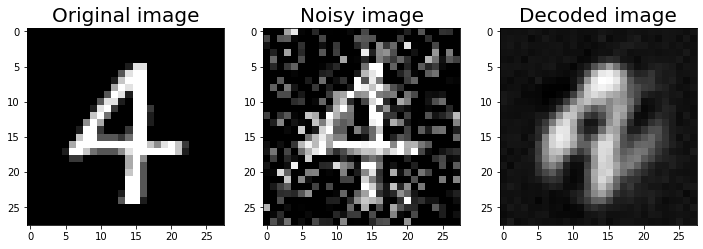

In [ ]:
fig=plt.figure(figsize=(12, 12))

_img = np.random.randint(X_test.shape[0])
_img = 5923
print(f'image {_img}')
img = X_test[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 1)
plt.title('Original image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_test_noisy[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 2)
plt.title('Noisy image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_decoded_Dense_1_n[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 3)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap = 'gray')

plt.show()

##### Representación latente aplicada

In [ ]:
# Representación latente comprimida
encoded_test_Dense_1_n = E_Dense_1_N.predict(X_test)
encoded_train_Dense_1_n = E_Dense_1_N.predict(X_train)

In [ ]:
modelaux = Sequential([
  Dense(64, activation='relu', input_shape=(ENC_DIM,)),
  Dense(32, activation='relu'),
  Dense(10, activation='softmax'),])

# Compilado
modelaux.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

# One-hot-encoding
Y_test_oneHot = keras.utils.to_categorical(Y_test, num_classes=10)
Y_train_oneHot = keras.utils.to_categorical(Y_train, num_classes=10)

modelaux.fit(encoded_train_Dense_1_n, Y_train_oneHot,batch_size=256,epochs=20)

Epoch 1/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.9368 - accuracy: 0.7224
Epoch 2/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.3886 - accuracy: 0.8844
Epoch 3/20
60000/60000 [==============================] - 1s 13us/step - loss: 0.3218 - accuracy: 0.9040
Epoch 4/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.2849 - accuracy: 0.9153
Epoch 5/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.2581 - accuracy: 0.9227
Epoch 6/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.2368 - accuracy: 0.9290
Epoch 7/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.2197 - accuracy: 0.9342
Epoch 8/20
60000/60000 [==============================] - 1s 11us/step - loss: 0.2048 - accuracy: 0.9376
Epoch 9/20
60000/60000 [==============================] - 1s 12us/step - loss: 0.1923 - accuracy: 0.9414
Epoch 10/20
60000/60000 [==============================

In [ ]:
results = modelaux.predict(encoded_test_Dense_1_n)
y_predict = np.argmax(results, axis=1)
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.96      0.96       892
           6       0.97      0.96      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.94      0.95       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
print('Macro-F1-Score:', f1_score(Y_test, y_predict, average='macro'))

Macro-F1-Score: 0.9605307714372717


#### Representación t-SNE

In [ ]:
import seaborn as sns
import pandas as pd

# X is a matrix resulting from a dimensionality reduction method such as PCA
# Y is a list of labels for each instance
# c1 and c2 are column indices corresponding to the components that we wish to plot
# N is the number of instances
def nice_scatterplot(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})

In [ ]:
from sklearn.manifold import TSNE

# Deep Encoder - Shallow Decoder
tsne = TSNE()
X_tsne_n_1 = tsne.fit_transform(encoded_test_Dense_n_1[:10000])

# Shallow Encoder - Deep Decoder
tsne = TSNE()
X_tsne_1_n = tsne.fit_transform(encoded_test_Dense_1_n[:10000])

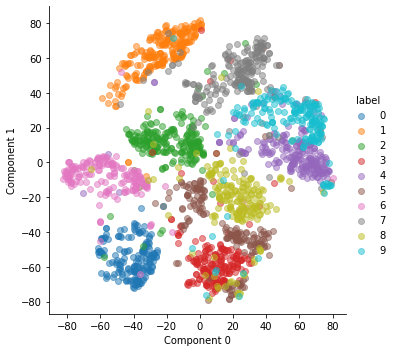

In [ ]:
# Deep Encoder - Shallow Decoder
nice_scatterplot(X_tsne_n_1, Y_test, 0, 1, N=2000)

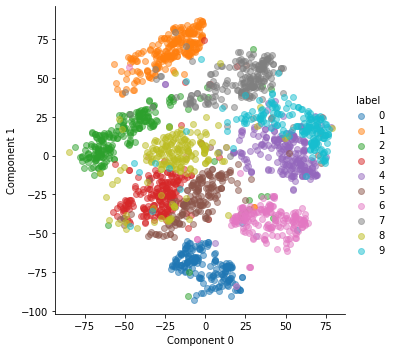

In [ ]:
# Shallow Encoder - Deep Decoder
nice_scatterplot(X_tsne_1_n, Y_test, 0, 1, N=2000)

### Convolucional

In [ ]:
ENC_DIM = 4
EPOCHS = 10
BATCH_SIZE = 128

from tensorflow.keras.datasets import mnist
# Cargar Dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalizar
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [ ]:
#### Aplicando Ruido a ambos conjuntos
# Parametros
_mean = 0.0
_desv = 0.5

# Trainning set
noise = np.random.normal(loc = _mean, scale = _desv, size=X_train.shape)
X_train_noisy = X_train + noise
X_train_noisy = np.clip(X_train_noisy, 0., 1.)

# Testing set
noise = np.random.normal(loc = _mean, scale = _desv, size=X_test.shape)
X_test_noisy = X_test + noise
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

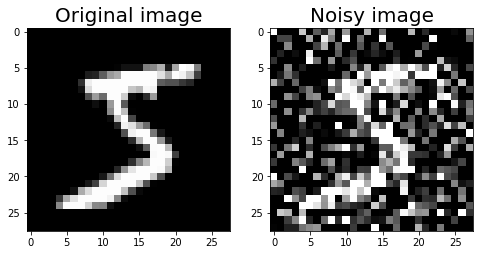

In [ ]:
fig=plt.figure(figsize=(8, 8))

img = X_train[0].reshape(28, 28)
fig.add_subplot(1, 2, 1)
plt.title('Original image', fontsize=20)
plt.imshow(img, cmap='gray')

img = X_train_noisy[0].reshape(28, 28)
fig.add_subplot(1, 2, 2)
plt.title('Noisy image', fontsize=20)
plt.imshow(img, cmap='gray')

plt.show()

#### Deep Encoder - Shallow Decoder [3:1]

##### Arquitectura

In [ ]:
def Red(dim_encod):
  input_img = Input(shape=(28, 28, 1))

  # Encoder Layers
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  encoded = Conv2D(dim_encod, (1, 1), activation='relu', padding='same', name ="Embedding")(x)

  # Decoder Layers
  decoded = Conv2DTranspose(1, (4,4), strides=(4,4), input_shape=(7,7,dim_encod))(encoded)

  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder
AE_1, E_1 = Red(ENC_DIM)

In [ ]:
AE_1.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
Embedding (Conv2D)           (None, 7, 7, 4)           132       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         65 

In [ ]:
AE_1.fit(X_train_noisy, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0510 - val_loss: 0.0266
Epoch 2/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0278 - val_loss: 0.0197
Epoch 3/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0255 - val_loss: 0.0188
Epoch 4/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.0249 - val_loss: 0.0184
Epoch 5/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0245 - val_loss: 0.0182
Epoch 6/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0243 - val_loss: 0.0180
Epoch 7/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0241 - val_loss: 0.0180
Epoch 8/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.0240 - val_loss: 0.0180
Epoch 9/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.0239 - val_loss: 0.0179
Epoch

##### Resultados

In [ ]:
X_decoded_Conv_n_1 = AE_1.predict(X_test)
Z_embedding_Conv_test_n_1 = E_1.predict(X_test)
Z_embedding_Conv_train_n_1 = E_1.predict(X_train)

image 5923


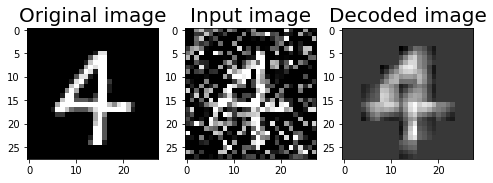

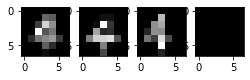

In [ ]:
fig=plt.figure(figsize=(8, 8))

_img = np.random.randint(X_test.shape[0])
_img = 5923
print(f'image {_img}')

img = X_test[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 1)
plt.title('Original image', fontsize=20)
plt.imshow(img, cmap='gray')

img = X_test_noisy[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 2)
plt.title('Input image', fontsize=20)
plt.imshow(img, cmap='gray')

img = X_decoded_Conv_n_1[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 3)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap='gray')
plt.show()

fig=plt.figure(figsize=(4, 4))
for i in range(ENC_DIM):
  fig.add_subplot(1, ENC_DIM, i+1)
  plt.imshow(Z_embedding_Conv_test_n_1[_img][:,:,i], cmap='gray')
plt.show()

##### Representación latente aplicada

In [ ]:
##model building
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(7,7,4)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
# Compilado
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

# One-hot-encoding
Y_test_oneHot = keras.utils.to_categorical(Y_test, num_classes=10)
Y_train_oneHot = keras.utils.to_categorical(Y_train, num_classes=10)

model.fit(Z_embedding_Conv_train_n_1, Y_train_oneHot,batch_size=256,epochs=20)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 5, 5, 32)          1184      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)              

In [ ]:
results = model.predict(Z_embedding_Conv_test_n_1)
y_predict = np.argmax(results, axis=1)
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.97      0.96       892
           6       0.99      0.96      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.97      0.98      0.97       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
print('Macro-F1-Score:', f1_score(Y_test, y_predict, average='macro'))

Macro-F1-Score: 0.9729018730278307


#### Shallow Encoder - Deep Decoder [1:3]

##### Arquitectura

In [ ]:
def Red2(dim_encod):
  input_img = Input(shape=(28, 28, 1))

  # Encoder Layers
  x = Conv2D(dim_encod, (3, 3), activation='relu', padding='same')(input_img)
  encoded = MaxPooling2D((4, 4), padding='same', name="embedding")(x)

  # Decoder Layers
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D(2)(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D(2)(x)

  decoded = Conv2D(1, (3,3), activation='relu', padding='same')(x)

  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder
AE_2, E_2 = Red2(ENC_DIM)

In [ ]:
AE_2.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 4)         40        
_________________________________________________________________
embedding (MaxPooling2D)     (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 32)          1184      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 28, 28, 16)        0  

In [ ]:
AE_2.fit(X_train_noisy, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.0339 - val_loss: 0.0213
Epoch 2/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0254 - val_loss: 0.0185
Epoch 3/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0231 - val_loss: 0.0174
Epoch 4/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0221 - val_loss: 0.0158
Epoch 5/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0215 - val_loss: 0.0153
Epoch 6/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0211 - val_loss: 0.0147
Epoch 7/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0208 - val_loss: 0.0149
Epoch 8/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0206 - val_loss: 0.0143
Epoch 9/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.0204 - val_loss: 0.0142
Epoch

##### Resultados

In [ ]:
X_decoded_Conv_1_n = AE_2.predict(X_test)
Z_embedding_Conv_test_1_n = E_2.predict(X_test)
Z_embedding_Conv_train_1_n = E_2.predict(X_train)

image 5923


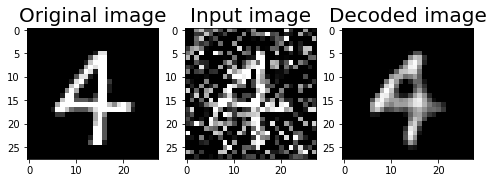

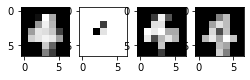

In [ ]:
fig=plt.figure(figsize=(8, 8))

_img = np.random.randint(X_test.shape[0])
_img = 5923
print(f'image {_img}')

img = X_test[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 1)
plt.title('Original image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_test_noisy[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 2)
plt.title('Input image', fontsize=20)
plt.imshow(img, cmap = 'gray')

img = X_decoded_Conv_1_n[ _img ].reshape(28, 28)
fig.add_subplot(1, 3, 3)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap = 'gray')

plt.show()

fig=plt.figure(figsize=(4, 4))
for i in range(ENC_DIM):
  fig.add_subplot(1, ENC_DIM, i+1)
  plt.imshow(Z_embedding_Conv_test_1_n[_img][:,:,i], cmap = 'gray')
plt.show()

##### Representación latente aplicada

In [ ]:
##model building
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(7,7,4)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()
# Compilado
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

# One-hot-encoding
Y_test_oneHot = keras.utils.to_categorical(Y_test, num_classes=10)
Y_train_oneHot = keras.utils.to_categorical(Y_train, num_classes=10)

model.fit(Z_embedding_Conv_train_1_n, Y_train_oneHot,batch_size=256,epochs=20)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 5, 5, 32)          1184      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

In [ ]:
results = model.predict(Z_embedding_Conv_test_1_n)
y_predict = np.argmax(results, axis=1)
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
print('Macro-F1-Score:', f1_score(Y_test, y_predict, average='macro'))

Macro-F1-Score: 0.9761087528945718


# CAT DOG DATASET

In [ ]:
PATH = "drive/My Drive/ANN1/PetImages"
EPOCHS = 20
BATCH_SIZE = 128
VAL_SPLIT = 0.1
FILTERS = 12
SHAPE = (100,100,1)

In [ ]:
import os
import pickle 
X = pickle.load(open(os.path.join(PATH,"X3.pickle"),"rb"))
y = pickle.load(open(os.path.join(PATH,"y3.pickle"),"rb"))

In [ ]:
def shuffleImages(img_array, labels):
  aux_arr = []
  X = []
  y = []
  for i in range(len(labels)):
    aux_arr.append([img_array[i], labels[i]])
  random.shuffle(aux_arr)
  for img_arr, lab in aux_arr:
    X.append(img_arr)
    y.append(lab)
  return (np.array(X),np.array(y))

In [ ]:
X, y = shuffleImages(X, y)
X = X/255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Deep Encoder - Shallow Decoder [5:1]

### Arquitectura

In [ ]:
def Red(dim_encod,shape):
  input_img = Input(shape=shape)

  # Encoder Layers
  x = Conv2D(16, (2, 2), activation='relu', padding='same')(input_img)
  x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(dim_encod, (2, 2), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="embedding")(x)


  # Decoder Layers
  x = UpSampling2D(2)(encoded)
  decoded = Conv2DTranspose(1, (4,4), strides=(4,4),activation='sigmoid')(x)
  decoded_cropping = Cropping2D(2)(decoded)


  # Models
  autoencoder = Model(input_img, decoded_cropping)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder
AE_1, E_1 = Red(FILTERS,SHAPE)

In [ ]:
AE_1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 100, 16)      80        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 100, 100, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 32)        4128      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 50, 50, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 64)        0   

In [ ]:
AE_1.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

Train on 17960 samples, validate on 1996 samples
Epoch 1/15
17960/17960 [==============================] - 7s 373us/step - loss: 0.0355 - val_loss: 0.0182
Epoch 2/15
17960/17960 [==============================] - 6s 359us/step - loss: 0.0166 - val_loss: 0.0159
Epoch 3/15
17960/17960 [==============================] - 6s 360us/step - loss: 0.0155 - val_loss: 0.0152
Epoch 4/15
17960/17960 [==============================] - 7s 363us/step - loss: 0.0150 - val_loss: 0.0149
Epoch 5/15
17960/17960 [==============================] - 6s 359us/step - loss: 0.0147 - val_loss: 0.0148
Epoch 6/15
17960/17960 [==============================] - 7s 363us/step - loss: 0.0145 - val_loss: 0.0145
Epoch 7/15
17960/17960 [==============================] - 7s 362us/step - loss: 0.0144 - val_loss: 0.0144
Epoch 8/15
17960/17960 [==============================] - 7s 364us/step - loss: 0.0143 - val_loss: 0.0143
Epoch 9/15
17960/17960 [==============================] - 7s 363us/step - loss: 0.0142 - val_loss: 0.01

### Resultados

image 1251


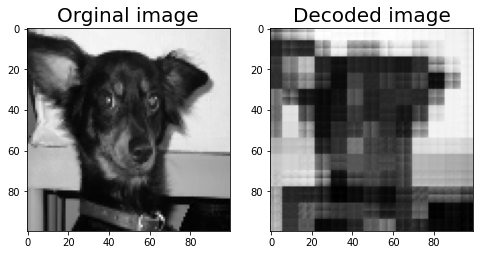

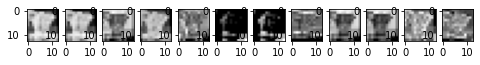

In [ ]:
X_decoded = AE_1.predict(X_test)
Z_embedding_n_1_test = E_1.predict(X_test)
Z_embedding_n_1_train = E_1.predict(X_train)

shape = 100
fig=plt.figure(figsize=(8, 8))

_img = np.random.randint(X_test.shape[0])
print(f'image {_img}')
_img = 2739

img = X_test[ _img ].reshape(shape, shape)
fig.add_subplot(1, 2, 1)
plt.title('Orginal image', fontsize=20)
plt.imshow(img, cmap="gray")

img = X_decoded[ _img ].reshape(shape, shape)
fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap="gray")
plt.show()

fig=plt.figure(figsize=(8, 8))
for i in range(FILTERS):
  fig.add_subplot(1, FILTERS, i+1)
  plt.imshow(Z_embedding_n_1_test[_img][:,:,i], cmap="gray")
plt.show()

## Shallow Encoder - Deep Decoder [1:3] Deconvolucionales

### Arquitectura

In [ ]:
def Red2(dim_encod, shape):
  input_img = Input(shape=shape)

  # Encoder Layers
  x = Conv2D(dim_encod, (3,3), activation='relu', padding='same')(input_img)
  encoded = MaxPooling2D((8,8), padding='same', name='embedding')(x)

  # Decoder Layers
  x = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), activation='relu')(encoded)
  x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), activation='relu')(x)
  x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
  decoded = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2), activation='sigmoid')(x)
  decoded_cropping = Cropping2D(2)(decoded)

  # Models
  autoencoder = Model(input_img, decoded_cropping)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder
AE_2, E_2 = Red2(FILTERS, SHAPE)

In [ ]:
AE_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 12)      120       
_________________________________________________________________
embedding (MaxPooling2D)     (None, 13, 13, 12)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 64)        3136      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        8224      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 52, 52, 32)        4128      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 16)        2064

In [ ]:
AE_2.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

Train on 17960 samples, validate on 1996 samples
Epoch 1/20
17960/17960 [==============================] - 4s 242us/step - loss: 0.0310 - val_loss: 0.0148
Epoch 2/20
17960/17960 [==============================] - 4s 221us/step - loss: 0.0137 - val_loss: 0.0132
Epoch 3/20
17960/17960 [==============================] - 4s 225us/step - loss: 0.0128 - val_loss: 0.0126
Epoch 4/20
17960/17960 [==============================] - 4s 222us/step - loss: 0.0123 - val_loss: 0.0121
Epoch 5/20
17960/17960 [==============================] - 4s 224us/step - loss: 0.0119 - val_loss: 0.0118
Epoch 6/20
17960/17960 [==============================] - 4s 224us/step - loss: 0.0117 - val_loss: 0.0117
Epoch 7/20
17960/17960 [==============================] - 4s 223us/step - loss: 0.0115 - val_loss: 0.0116
Epoch 8/20
17960/17960 [==============================] - 4s 222us/step - loss: 0.0113 - val_loss: 0.0113
Epoch 9/20
17960/17960 [==============================] - 4s 223us/step - loss: 0.0111 - val_loss: 0.01

### Resultados

image 513


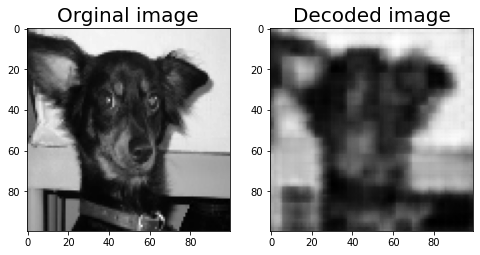

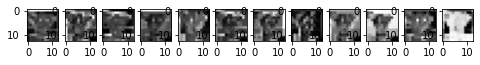

In [ ]:
X_decoded = AE_2.predict(X_test)
Z_embedding_Conv2dTransponse_test = E_2.predict(X_test)
Z_embedding_Conv2dTransponse_train = E_2.predict(X_train)

fig=plt.figure(figsize=(8, 8))

_img = np.random.randint(X_test.shape[0])
print(f'image {_img}')
_img = 2739

img = X_test[ _img ].reshape(100, 100)
fig.add_subplot(1, 2, 1)
plt.title('Orginal image', fontsize=20)
plt.imshow(img, cmap="gray")

img = X_decoded[ _img ].reshape(100, 100)
fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap="gray")

plt.show()

fig=plt.figure(figsize=(8, 8))
for i in range(FILTERS):
  fig.add_subplot(1, FILTERS, i+1)
  plt.imshow(Z_embedding_Conv2dTransponse_test[_img][:,:,i], cmap="gray")
plt.show()

## Shallow Encoder - Deep Decoder [1:3] UpSampling

### Arquitectura

In [ ]:
def Red3(dim_encod, shape):
  input_img = Input(shape=shape)

  # Encoder Layers
  x = Conv2D(dim_encod, (3,3), activation='relu', padding='same')(input_img)
  encoded = MaxPooling2D((8,8), padding='same', name='embedding')(x)

  # Decoder Layers
  x = UpSampling2D(2)(encoded)
  x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
  x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = UpSampling2D(2)(x)
  x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
  x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
  x = UpSampling2D(2)(x)
  decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
  decoded_cropping = Cropping2D(2)(decoded)


  # Models
  autoencoder = Model(input_img, decoded_cropping)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder
AE_3, E_3 = Red3(FILTERS, SHAPE)

In [ ]:
AE_3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 12)      120       
_________________________________________________________________
embedding (MaxPooling2D)     (None, 13, 13, 12)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 12)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 64)        6976      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 32)        8224      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 52, 52, 32)        0   

In [ ]:
AE_3.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

Train on 17960 samples, validate on 1996 samples
Epoch 1/20
17960/17960 [==============================] - 6s 335us/step - loss: 0.0205 - val_loss: 0.0125
Epoch 2/20
17960/17960 [==============================] - 6s 312us/step - loss: 0.0117 - val_loss: 0.0113
Epoch 3/20
17960/17960 [==============================] - 6s 313us/step - loss: 0.0108 - val_loss: 0.0105
Epoch 4/20
17960/17960 [==============================] - 6s 315us/step - loss: 0.0103 - val_loss: 0.0101
Epoch 5/20
17960/17960 [==============================] - 6s 315us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 6/20
17960/17960 [==============================] - 6s 314us/step - loss: 0.0096 - val_loss: 0.0095
Epoch 7/20
17960/17960 [==============================] - 6s 313us/step - loss: 0.0094 - val_loss: 0.0093
Epoch 8/20
17960/17960 [==============================] - 6s 312us/step - loss: 0.0092 - val_loss: 0.0092
Epoch 9/20
17960/17960 [==============================] - 6s 313us/step - loss: 0.0091 - val_loss: 0.00

### Resultados

image 2739


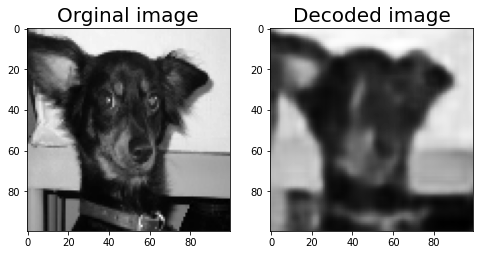

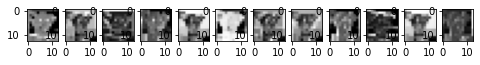

In [ ]:
X_decoded = AE_3.predict(X_test)
Z_embedding_UpSampling_test = E_3.predict(X_test)
Z_embedding_UpSampling_train = E_3.predict(X_train)

fig=plt.figure(figsize=(8, 8))

_img = np.random.randint(X_test.shape[0])
print(f'image {_img}')


img = X_test[ _img ].reshape(100, 100)
fig.add_subplot(1, 2, 1)
plt.title('Orginal image', fontsize=20)
plt.imshow(img, cmap="gray")

img = X_decoded[ _img ].reshape(100, 100)
fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(img, cmap="gray")

plt.show()

fig=plt.figure(figsize=(8, 8))
for i in range(FILTERS):
  fig.add_subplot(1, FILTERS, i+1)
  plt.imshow(Z_embedding_UpSampling_test[_img][:,:,i], cmap="gray")
plt.show()

## Clasificador 

In [ ]:
BATCH_SIZE = 128
EPOCHS = 15
DIM = 13

In [ ]:
import keras
from sklearn.metrics import accuracy_score, classification_report
##Arquitectura 
def clf_modelo(shape):
  model1 = keras.models.Sequential()

  model1.add(keras.layers.Conv2D(32, (3,3), input_shape = shape, activation="relu",))
  model1.add(keras.layers.Dropout(0.25))
  model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


  #model1.add( keras.layers.Conv2D(64, (3,3),  activation="relu"))
  #model1.add(keras.layers.Dropout(0.25))
  #model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

  model1.add( keras.layers.Conv2D(128, (3,3),  activation="relu"))
  model1.add(keras.layers.Dropout(0.25))
  model1.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


  model1.add( keras.layers.Flatten())

  model1.add( keras.layers.Dense(512, activation="relu"))
  model1.add(keras.layers.Dropout(0.5))

  model1.add( keras.layers.Dense(1, activation="sigmoid"))


  model1.compile(optimizer="adam",
                loss="binary_crossentropy",
                metrics=["accuracy"])
  return model1

In [ ]:
model = clf_modelo((100,100,1))
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
19956/19956 [==============================] - 9s 446us/step - loss: 0.7200 - accuracy: 0.6074
Epoch 2/15
19956/19956 [==============================] - 9s 436us/step - loss: 0.5396 - accuracy: 0.7286
Epoch 3/15
19956/19956 [==============================] - 9s 434us/step - loss: 0.4561 - accuracy: 0.7860
Epoch 4/15
19956/19956 [==============================] - 9s 436us/step - loss: 0.3965 - accuracy: 0.8192
Epoch 5/15
19956/19956 [==============================] - 9s 435us/step - loss: 0.3425 - accuracy: 0.8510
Epoch 6/15
19956/19956 [==============================] - 9s 437us/step - loss: 0.2660 - accuracy: 0.8870
Epoch 7/15
19956/19956 [==============================] - 9s 437us/step - loss: 0.1914 - accuracy: 0.9266
Epoch 8/15
19956/19956 [==============================] - 9s 436us/step - loss: 0.1371 - accuracy: 0.9497
Epoch 9/15
19956/19956 [==============================] - 9s 436us/step - loss: 0.1001 - accuracy: 0.9658
Epoch 10/15
19956/19956 [=====================

In [ ]:
mode_n_1 = clf_modelo((DIM,DIM,FILTERS))
mode_n_1.fit(Z_embedding_n_1_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
19956/19956 [==============================] - 1s 44us/step - loss: 0.6944 - accuracy: 0.5593
Epoch 2/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.6605 - accuracy: 0.5967
Epoch 3/15
19956/19956 [==============================] - 1s 38us/step - loss: 0.6539 - accuracy: 0.6159
Epoch 4/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.6446 - accuracy: 0.6254
Epoch 5/15
19956/19956 [==============================] - 1s 34us/step - loss: 0.6350 - accuracy: 0.6369
Epoch 6/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.6291 - accuracy: 0.6454
Epoch 7/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.6220 - accuracy: 0.6506
Epoch 8/15
19956/19956 [==============================] - 1s 34us/step - loss: 0.6163 - accuracy: 0.6552
Epoch 9/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.6125 - accuracy: 0.6591
Epoch 10/15
19956/19956 [==============================

In [ ]:
mode_Conv2dTransponse = clf_modelo((DIM,DIM,FILTERS))
mode_Conv2dTransponse.fit(Z_embedding_Conv2dTransponse_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
19956/19956 [==============================] - 1s 44us/step - loss: 0.6797 - accuracy: 0.5624
Epoch 2/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.6203 - accuracy: 0.6543
Epoch 3/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.5752 - accuracy: 0.7010
Epoch 4/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.5548 - accuracy: 0.7162
Epoch 5/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.5374 - accuracy: 0.7307
Epoch 6/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.5276 - accuracy: 0.7382
Epoch 7/15
19956/19956 [==============================] - 1s 37us/step - loss: 0.5133 - accuracy: 0.7492
Epoch 8/15
19956/19956 [==============================] - 1s 37us/step - loss: 0.4995 - accuracy: 0.7587
Epoch 9/15
19956/19956 [==============================] - 1s 37us/step - loss: 0.4917 - accuracy: 0.7641
Epoch 10/15
19956/19956 [==============================

In [ ]:
mode_UpSampling = clf_modelo((DIM,DIM,FILTERS))
mode_UpSampling.fit(Z_embedding_UpSampling_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
19956/19956 [==============================] - 1s 44us/step - loss: 0.6557 - accuracy: 0.6018
Epoch 2/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.5955 - accuracy: 0.6832
Epoch 3/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.5614 - accuracy: 0.7136
Epoch 4/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.5392 - accuracy: 0.7287
Epoch 5/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.5210 - accuracy: 0.7439
Epoch 6/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.5051 - accuracy: 0.7553
Epoch 7/15
19956/19956 [==============================] - 1s 36us/step - loss: 0.4928 - accuracy: 0.7616
Epoch 8/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.4758 - accuracy: 0.7720
Epoch 9/15
19956/19956 [==============================] - 1s 35us/step - loss: 0.4637 - accuracy: 0.7808
Epoch 10/15
19956/19956 [==============================

### Scores

In [ ]:
y_predict = model.predict(X_test)
y_predict = (y_predict>0.5).astype(int)
#accuracy_score(y_test, y_predict)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      2574
           1       0.77      0.82      0.79      2416

    accuracy                           0.79      4990
   macro avg       0.79      0.79      0.79      4990
weighted avg       0.79      0.79      0.79      4990



In [ ]:
y_predict_n_1 = mode_n_1.predict(Z_embedding_n_1_test)
y_predict_n_1 = (y_predict_n_1>0.5).astype(int)
#accuracy_score(y_test, y_predict_n_1)
print(classification_report(y_test, y_predict_n_1))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2574
           1       0.68      0.70      0.69      2416

    accuracy                           0.69      4990
   macro avg       0.69      0.69      0.69      4990
weighted avg       0.69      0.69      0.69      4990



In [ ]:
y_predict_Conv2dTransponse = mode_Conv2dTransponse.predict(Z_embedding_Conv2dTransponse_test)
y_predict_Conv2dTransponse = (y_predict_Conv2dTransponse>0.5).astype(int)
#accuracy_score(y_test, y_predict_Conv2dTransponse)
print(classification_report(y_test, y_predict_Conv2dTransponse))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      2574
           1       0.82      0.68      0.74      2416

    accuracy                           0.77      4990
   macro avg       0.78      0.77      0.77      4990
weighted avg       0.78      0.77      0.77      4990



In [ ]:
y_predict_UpSampling = mode_UpSampling.predict(Z_embedding_UpSampling_test)
y_predict_UpSampling = (y_predict_UpSampling>0.5).astype(int)
#accuracy_score(y_test, y_predict_UpSampling)
print(classification_report(y_test, y_predict_UpSampling))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      2574
           1       0.83      0.68      0.75      2416

    accuracy                           0.78      4990
   macro avg       0.78      0.77      0.77      4990
weighted avg       0.78      0.78      0.77      4990



# DENOISING DOCUMENTS

## Load data

In [ ]:
PATH = "drive/My Drive/t2_ann"
EPOCHS = 30
BATCH_SIZE = 8
FILTROS_EMB = 16
SHAPE = (260,540,1)

In [ ]:
import os
import pickle
from PIL import Image
X_train = pickle.load(open(os.path.join(PATH,"train_clean3.pickle"),"rb"))
X_train_noisy = pickle.load(open(os.path.join(PATH,"train_dirty3.pickle"),"rb"))
X_test = pickle.load(open(os.path.join(PATH,"test3.pickle"),"rb"))

In [ ]:
# Reshape
X_train = X_train.reshape(-1,260,540,1)
X_train_noisy = X_train_noisy.reshape(-1,260,540,1)
X_test = X_test.reshape(-1,260,540,1)

# Normalize
X_train = X_train/255.
X_train_noisy = X_train_noisy/255.
X_test = X_test/255.

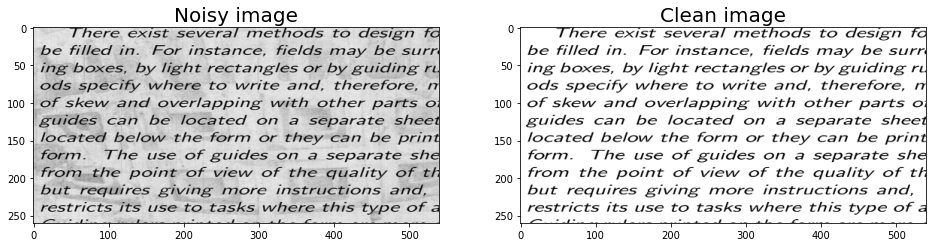

In [ ]:
fig=plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.title('Noisy image', fontsize=20)
plt.imshow(X_train_noisy[2].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Clean image', fontsize=20)
plt.imshow(X_train[2].reshape(260,540), cmap='gray')
plt.show()

## Deep Encoder - Shallow Decoder

### Arquitectura

In [ ]:
def Red(shape, filtros_emb):
  input_img = Input(shape=shape)

  # Encoder Layers
  x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2,2), padding='same')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2,2), padding='same')(x)
  encoded = Conv2D(64, (3,3), activation='relu', padding='same', name='embedding')(x)

  # Decoder Layers
  decoded = Conv2DTranspose(1, (4,4), strides=(4,4))(encoded)

  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='nadam', loss='mse')
  return autoencoder, encoder
AE_1, E_1 = Red(SHAPE,FILTROS_EMB)

In [ ]:
AE_1.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 260, 540, 1)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 260, 540, 16)      160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 130, 270, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 130, 270, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 65, 135, 32)       0         
_________________________________________________________________
embedding (Conv2D)           (None, 65, 135, 64)       18496     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 260, 540, 1)       102

In [ ]:
history_AE_1 = AE_1.fit(X_train_noisy, X_train, epochs=EPOCHS, batch_size=8, validation_split=0.2)

Train on 115 samples, validate on 29 samples
Epoch 1/30
115/115 [==============================] - 14s 123ms/step - loss: 0.3415 - val_loss: 0.0730
Epoch 2/30
115/115 [==============================] - 14s 121ms/step - loss: 0.0834 - val_loss: 0.0734
Epoch 3/30
115/115 [==============================] - 14s 121ms/step - loss: 0.0766 - val_loss: 0.0967
Epoch 4/30
115/115 [==============================] - 14s 121ms/step - loss: 0.0746 - val_loss: 0.0783
Epoch 5/30
115/115 [==============================] - 14s 120ms/step - loss: 0.0737 - val_loss: 0.0550
Epoch 6/30
115/115 [==============================] - 14s 120ms/step - loss: 0.0667 - val_loss: 0.0627
Epoch 7/30
115/115 [==============================] - 14s 120ms/step - loss: 0.0628 - val_loss: 0.0495
Epoch 8/30
115/115 [==============================] - 14s 120ms/step - loss: 0.0594 - val_loss: 0.0467
Epoch 9/30
115/115 [==============================] - 14s 121ms/step - loss: 0.0562 - val_loss: 0.0489
Epoch 10/30
115/115 [=======

### Resultados

In [ ]:
X_decoded = AE_1.predict(X_test)

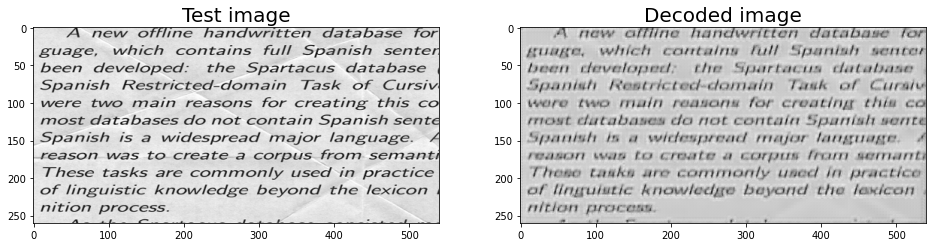

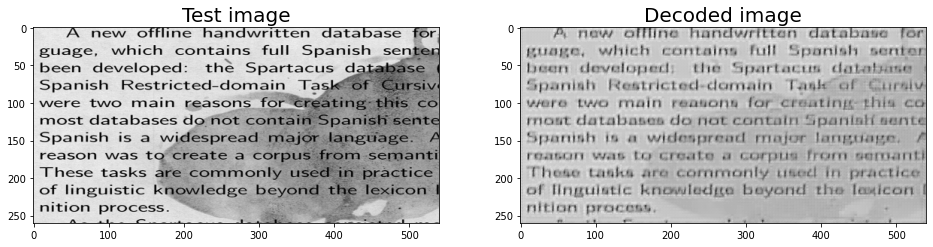

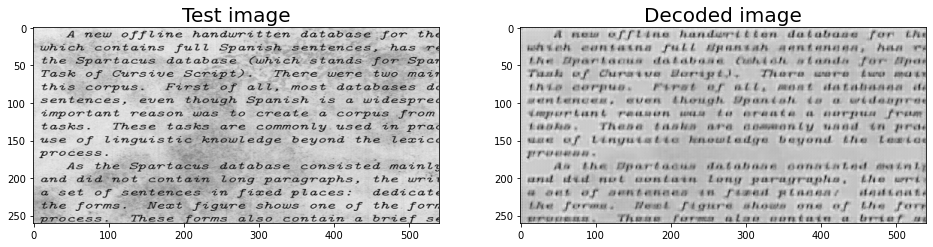

In [ ]:
fig=plt.figure(figsize=(16, 16))
_img = [2,5,38]
fig.add_subplot(1, 2, 1)
plt.title('Test image', fontsize=20)
plt.imshow(X_test[_img[0]].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(X_decoded[_img[0]].reshape(260,540), cmap='gray')
plt.show()

fig=plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.title('Test image', fontsize=20)
plt.imshow(X_test[_img[1]].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(X_decoded[_img[1]].reshape(260,540), cmap='gray')
plt.show()

fig=plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.title('Test image', fontsize=20)
plt.imshow(X_test[_img[2]].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(X_decoded[_img[2]].reshape(260,540), cmap='gray')
plt.show()

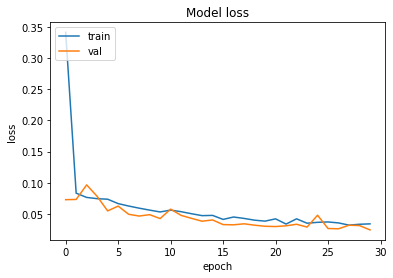

In [ ]:
plt.plot(history_AE_1.history['loss'])
plt.plot(history_AE_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Shallow Encoder - Deep Decoder

### Arquitectura

In [ ]:
def Red2(shape, filtros_emb):
  input_img = Input(shape=shape)

  # Encoder Layers
  x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
  encoded = MaxPooling2D((4,4), padding='same', name='embedding')(x)

  # Decoder Layers
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(encoded)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

  # Models
  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)
  autoencoder.compile(optimizer='nadam', loss='mse')
  return autoencoder, encoder
AE_3, E_3 = Red2(SHAPE,FILTROS_EMB)

In [ ]:
AE_3.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 260, 540, 1)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 260, 540, 64)      640       
_________________________________________________________________
embedding (MaxPooling2D)     (None, 65, 135, 64)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 65, 135, 64)       36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 130, 270, 64)      0         
_________________________________________________________________
Conv4 (Conv2D)               (None, 130, 270, 32)      18464     
_________________________________________________________________
upsample2 (UpSampling2D)     (None, 260, 540, 32)      0  

In [ ]:
history_AE_3 = AE_3.fit(X_train_noisy, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 115 samples, validate on 29 samples
Epoch 1/30
115/115 [==============================] - 54s 472ms/step - loss: 0.0921 - val_loss: 0.0557
Epoch 2/30
115/115 [==============================] - 54s 471ms/step - loss: 0.0603 - val_loss: 0.0477
Epoch 3/30
115/115 [==============================] - 54s 471ms/step - loss: 0.0514 - val_loss: 0.0454
Epoch 4/30
115/115 [==============================] - 54s 473ms/step - loss: 0.0457 - val_loss: 0.0352
Epoch 5/30
115/115 [==============================] - 54s 470ms/step - loss: 0.0414 - val_loss: 0.0311
Epoch 6/30
115/115 [==============================] - 54s 470ms/step - loss: 0.0384 - val_loss: 0.0286
Epoch 7/30
115/115 [==============================] - 59s 511ms/step - loss: 0.0346 - val_loss: 0.0264
Epoch 8/30
115/115 [==============================] - 54s 472ms/step - loss: 0.0322 - val_loss: 0.0251
Epoch 9/30
115/115 [==============================] - 54s 470ms/step - loss: 0.0306 - val_loss: 0.0250
Epoch 10/30
115/115 [=======

### Resultados

In [ ]:
X_decoded = AE_3.predict(X_test)

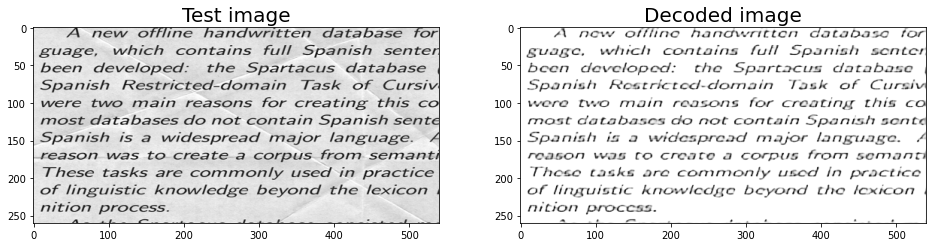

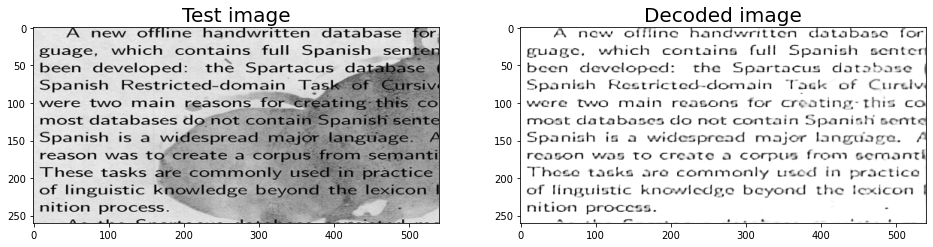

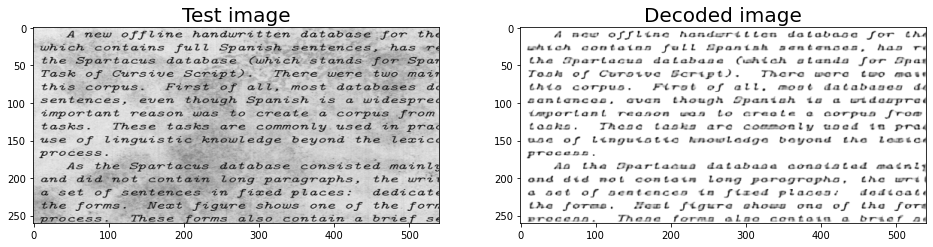

In [ ]:
fig=plt.figure(figsize=(16, 16))
_img = [2,5,38]
fig.add_subplot(1, 2, 1)
plt.title('Test image', fontsize=20)
plt.imshow(X_test[_img[0]].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(X_decoded[_img[0]].reshape(260,540), cmap='gray')
plt.show()

fig=plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.title('Test image', fontsize=20)
plt.imshow(X_test[_img[1]].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(X_decoded[_img[1]].reshape(260,540), cmap='gray')
plt.show()

fig=plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.title('Test image', fontsize=20)
plt.imshow(X_test[_img[2]].reshape(260,540), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Decoded image', fontsize=20)
plt.imshow(X_decoded[_img[2]].reshape(260,540), cmap='gray')
plt.show()

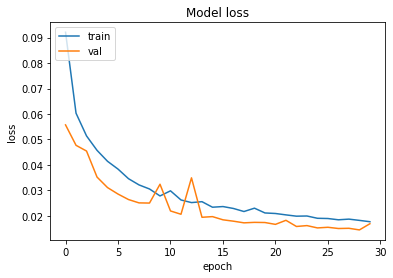

In [ ]:
plt.plot(history_AE_3.history['loss'])
plt.plot(history_AE_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## Comparación Loss

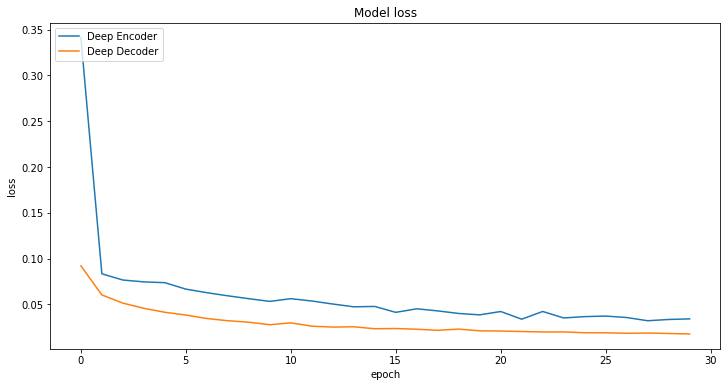

In [ ]:
fig=plt.figure(figsize=(12, 6))
plt.plot(history_AE_1.history['loss'])
plt.plot(history_AE_3.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Deep Encoder','Deep Decoder'], loc='upper left')
fig.show()

# KAGGLE CHALLENGE

In [1]:
!pip install emoji

     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=5fdbf86287eb88843f06cb4a043c9df66b85576ac1a8fa3dc3c0383e643dc61e
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [3]:

import re 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import emoji
import string

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
import nltk
import ast

import keras
from sklearn import preprocessing

from collections import Counter
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
def remove_puntation(text):
    punct =[]
    punct += list(string.punctuation)
    for p in punct:
        text = text.replace(p, ' ')
    return text

def remove_stop(text, lenguage):
    stop = set(stopwords.words(lenguage))
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def stemming(tokens):
    ps = nltk.PorterStemmer()
    text = [ps.stem(word) for word in tokens]
    return text
    
def clean_data(text, lenguage="english"):
    #remueve puntuacion
    text = text.strip()
    text = text.lower()
    text = remove_puntation(text)
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    text = text.replace("url", " ")
    text = remove_stop(text, lenguage)
    #remueve emojis
    text = text.encode("ascii", "ignore").decode("ascii")
    return text

In [5]:
train_source_tweets = []
test_source_tweets = []

with open("train_source_tweets.txt") as file:
    for line in file:
        tid, text = line.split("\t")
        row = [tid, clean_data(text)]
        train_source_tweets.append(row)

with open("test_source_tweets.txt") as file:
    for line in file:
        tid, text = line.split("\t")
        row = [tid, clean_data(text)]
        test_source_tweets.append(row)

In [6]:
labels = list(pd.read_csv("train_labels.csv").pop("label"))
c_l = Counter(labels)
le = preprocessing.LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)
labels_oneHot = keras.utils.to_categorical(labels_encoded)

print(c_l)

Counter({'non-rumor': 524, 'false': 520, 'true': 514, 'unverified': 368})


In [7]:
df_train = pd.DataFrame(train_source_tweets)
df_test = pd.DataFrame(test_source_tweets)
df_train.columns = ["id", "tweet"]
df_test.columns = ["id", "tweet"]

In [8]:
def counter_words(text):
    count = Counter()
    for i in text:
        for word in i.split():
            count[word]+=1
    return count

In [9]:
full_text = list(df_train["tweet"].values) + list(df_test["tweet"].values)
counter = counter_words(full_text)

num_words = len(counter)

In [10]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train.tweet)

In [11]:
train_seq = tokenizer.texts_to_sequences(df_train.tweet)
test_seq = tokenizer.texts_to_sequences(df_test.tweet)

In [12]:
from keras_preprocessing.sequence import pad_sequences

max_length = 16
train_padded = pad_sequences(train_seq, maxlen=max_length, padding="post",
                            truncating="post")
test_padded = pad_sequences(test_seq, maxlen=max_length, padding="post",
                            truncating="post")

## Modelo

In [47]:

from keras.regularizers import l1_l2


models = []

def model_s(neurons, dim_emb, l1_r, l2_r):
  model = Sequential()

  model.add(Embedding(input_dim=num_words, output_dim=dim_emb, input_length=max_length, activity_regularizer= l1_l2(l1=l1_r, l2=l2_r)))
  model.add(LSTM(neurons,  recurrent_dropout=0.5))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation="softmax"))
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  
  return  model

regul_model = model_s(16, 100, 1e-5, 1e-4 )
no_regul_model = model_s(16, 100, 0, 0)

In [50]:
hists_regul = regul_model.fit(train_padded, labels_oneHot, epochs=22, validation_split=0.2, batch_size=32, verbose=0)
hists_no_regul = no_regul_model.fit(train_padded, labels_oneHot, epochs=30, validation_split=0.2, batch_size=32, verbose=0)

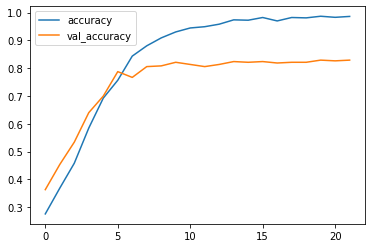

In [45]:
plt.plot(hists_regul.history["accuracy"], label="accuracy")
plt.plot(hists_regul.history["val_accuracy"], label="val_accuracy")
plt.legend()

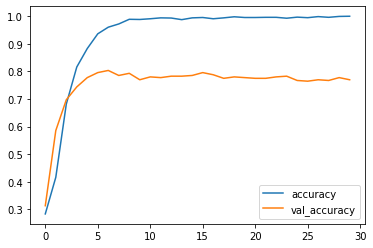

In [49]:
plt.plot(hists_no_regul_2.history["accuracy"], label="accuracy")
plt.plot(hists_no_regul_2.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [34]:
y_pred = regul_model.predict(test_padded)
y_pred = np.argmax(y_pred, axis=1)

In [35]:
y_pred = le.inverse_transform(y_pred)

In [36]:
result = pd.DataFrame(list(zip(y_pred,list(df_test.id))),columns=["label","id"])

In [37]:
result.to_csv("submission.csv",index=False)